In [465]:
import os
import pickle
import random as rn
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split 
from keras.layers.advanced_activations import LeakyReLU

pd.set_option('display.max_columns', 200)

In [466]:
def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    rn.seed(seed) # fix random function seed
    np.random.seed(seed) # fix numpy seed
    tf.random.set_seed(seed) # fix tensorflow seed

In [467]:
# Fix Random Seed
reset_seed(1234)

In [468]:
# Count File Numbers
data_dir = '/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step2_OptimumParameter/output_csv' #'/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Dataset' 
#Max ကိုရစေတဲ့ စစ်ထုတ်ထားတဲ့ Dataset ကိုသာ အသုံးပြုပါတယ်။ အကြောင်းက Max ကို ရစေတဲ့ Data တွေထဲမှာ Temp ကိုငယ်စဉ်ကြီးလိုက်စီတဲ့အခါ ရအောင်လို့ပါ။
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_num:",file_num)

# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    df_tmp = pd.read_csv(file_dir) #instead, can be read_pickle
    df_raw = pd.concat([df_raw, df_tmp])
df_raw.reset_index(drop=True, inplace=True)
print("df_raw.shape:", df_raw.shape)

df_raw.describe()

file_num: 10
df_raw.shape: (73250, 101)


,Unnamed: 0,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA,Best1_Count,Best2_Count,Best_P_HPMR_MEAN,Best1_P_HPMR_MIN,Best1_P_HPMR_MAX,Best1_P_HPMR_MEAN,Best1_P_HPMR_STD,Best2_P_HPMR_MIN,Best2_P_HPMR_MAX,Best2_P_HPMR_MEAN,Best2_P_HPMR_STD,Best_P_LPMR_MEAN,Best1_P_LPMR_MIN,Best1_P_LPMR_MAX,Best1_P_LPMR_MEAN,Best1_P_LPMR_STD,Best2_P_LPMR_MIN,Best2_P_LPMR_MAX,Best2_P_LPMR_MEAN,Best2_P_LPMR_STD,Best_MCHE_BTM_DT_MEAN,Best1_MCHE_BTM_DT_MIN,Best1_MCHE_BTM_DT_MAX,Best1_MCHE_BTM_DT_MEAN,Best1_MCHE_BTM_DT_STD,Best2_MCHE_BTM_DT_MIN,Best2_MCHE_BTM_DT_MAX,Best2_MCHE_BTM_DT_MEAN,Best2_MCHE_BTM_DT_STD,Best_MR_C1_MEAN,Best1_MR_C1_MIN,Best1_MR_C1_MAX,Best1_MR_C1_MEAN,Best1_MR_C1_STD,Best2_MR_C1_MIN,Best2_MR_C1_MAX,Best2_MR_C1_MEAN,Best2_MR_C1_STD,Best_MR_C2_MEAN,Best1_MR_C2_MIN,Best1_MR_C2_MAX,Best1_MR_C2_MEAN,Best1_MR_C2_STD,Best2_MR_C2_MIN,Best2_MR_C2_MAX,Best2_MR_C2_MEAN,Best2_MR_C2_STD,Best_MR_C3_MEAN,Best1_MR_C3_MIN,Best1_MR_C3_MAX,Best1_MR_C3_MEAN,Best1_MR_C3_STD,Best2_MR_C3_MIN,Best2_MR_C3_MAX,Best2_MR_C3_MEAN,Best2_MR_C3_STD,Best_FFF_Flow_pred_MEAN,Best1_FFF_Flow_pred_MIN,Best1_FFF_Flow_pred_MAX,Best1_FFF_Flow_pred_MEAN,Best1_FFF_Flow_pred_STD,Best2_FFF_Flow_pred_MIN,Best2_FFF_Flow_pred_MAX,Best2_FFF_Flow_pred_MEAN,Best2_FFF_Flow_pred_STD,Best_ThermalEff_pred_MEAN,Best1_ThermalEff_pred_MIN,Best1_ThermalEff_pred_MAX,Best1_ThermalEff_pred_MEAN,Best1_ThermalEff_pred_STD,Best2_ThermalEff_pred_MIN,Best2_ThermalEff_pred_MAX,Best2_ThermalEff_pred_MEAN,Best2_ThermalEff_pred_STD,Best_SpecPower_pred_MEAN,Best1_SpecPower_pred_MIN,Best1_SpecPower_pred_MAX,Best1_SpecPower_pred_MEAN,Best1_SpecPower_pred_STD,Best2_SpecPower_pred_MIN,Best2_SpecPower_pred_MAX,Best2_SpecPower_pred_MEAN,Best2_SpecPower_pred_STD,Best_MCHE_CB_Out_Temp_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_MIN,Best1_MCHE_CB_Out_Temp_pred_MAX,Best1_MCHE_CB_Out_Temp_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_STD,Best2_MCHE_CB_Out_Temp_pred_MIN,Best2_MCHE_CB_Out_Temp_pred_MAX,Best2_MCHE_CB_Out_Temp_pred_MEAN,Best2_MCHE_CB_Out_Temp_pred_STD
count,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,7.325000e+04,7.325000e+04,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.00000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,7.141500e+04,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000
mean,46831.414457,0.773096,92.597326,3.694651,1.775014,28.532628,51.763529,1.546086e+07,1.894295e+06,3.161543,7.547235,51.513307,50.849372,52.241119,51.562888,0.840526,50.411133,53.088123,51.720984,1.000231,1.710449,1.702701,1.727258,1.712882,0.015565,1.700688,1.755602,1.720026,0.021729,3.016024,2.485003,3.412396,2.941760,0.579085,2.124109,3.89202,2.948036,0.662771,40.376689,40.062992,40.701574,40.381433,0.388954,39.806456,40.995911,40.409357,0.447770,40.813251,40.343549,41.356246,40.845736,0.619351,39.935582,41.766592,40.832540,0.684982,13.174517,12.854175,13.407266,13.130754,0.339359,12.589293,13.593320,13.095004,0.376718,1340.177656,1143.852188,1541.210

In [469]:
# # Pretreatment of Dataset
df = df_raw.copy()
#df = df[df['Feasible'] != 0]
#df.drop(["Note", "Unnamed: 0"], axis = 1, inplace = True)
df.describe()

,Unnamed: 0,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA,Best1_Count,Best2_Count,Best_P_HPMR_MEAN,Best1_P_HPMR_MIN,Best1_P_HPMR_MAX,Best1_P_HPMR_MEAN,Best1_P_HPMR_STD,Best2_P_HPMR_MIN,Best2_P_HPMR_MAX,Best2_P_HPMR_MEAN,Best2_P_HPMR_STD,Best_P_LPMR_MEAN,Best1_P_LPMR_MIN,Best1_P_LPMR_MAX,Best1_P_LPMR_MEAN,Best1_P_LPMR_STD,Best2_P_LPMR_MIN,Best2_P_LPMR_MAX,Best2_P_LPMR_MEAN,Best2_P_LPMR_STD,Best_MCHE_BTM_DT_MEAN,Best1_MCHE_BTM_DT_MIN,Best1_MCHE_BTM_DT_MAX,Best1_MCHE_BTM_DT_MEAN,Best1_MCHE_BTM_DT_STD,Best2_MCHE_BTM_DT_MIN,Best2_MCHE_BTM_DT_MAX,Best2_MCHE_BTM_DT_MEAN,Best2_MCHE_BTM_DT_STD,Best_MR_C1_MEAN,Best1_MR_C1_MIN,Best1_MR_C1_MAX,Best1_MR_C1_MEAN,Best1_MR_C1_STD,Best2_MR_C1_MIN,Best2_MR_C1_MAX,Best2_MR_C1_MEAN,Best2_MR_C1_STD,Best_MR_C2_MEAN,Best1_MR_C2_MIN,Best1_MR_C2_MAX,Best1_MR_C2_MEAN,Best1_MR_C2_STD,Best2_MR_C2_MIN,Best2_MR_C2_MAX,Best2_MR_C2_MEAN,Best2_MR_C2_STD,Best_MR_C3_MEAN,Best1_MR_C3_MIN,Best1_MR_C3_MAX,Best1_MR_C3_MEAN,Best1_MR_C3_STD,Best2_MR_C3_MIN,Best2_MR_C3_MAX,Best2_MR_C3_MEAN,Best2_MR_C3_STD,Best_FFF_Flow_pred_MEAN,Best1_FFF_Flow_pred_MIN,Best1_FFF_Flow_pred_MAX,Best1_FFF_Flow_pred_MEAN,Best1_FFF_Flow_pred_STD,Best2_FFF_Flow_pred_MIN,Best2_FFF_Flow_pred_MAX,Best2_FFF_Flow_pred_MEAN,Best2_FFF_Flow_pred_STD,Best_ThermalEff_pred_MEAN,Best1_ThermalEff_pred_MIN,Best1_ThermalEff_pred_MAX,Best1_ThermalEff_pred_MEAN,Best1_ThermalEff_pred_STD,Best2_ThermalEff_pred_MIN,Best2_ThermalEff_pred_MAX,Best2_ThermalEff_pred_MEAN,Best2_ThermalEff_pred_STD,Best_SpecPower_pred_MEAN,Best1_SpecPower_pred_MIN,Best1_SpecPower_pred_MAX,Best1_SpecPower_pred_MEAN,Best1_SpecPower_pred_STD,Best2_SpecPower_pred_MIN,Best2_SpecPower_pred_MAX,Best2_SpecPower_pred_MEAN,Best2_SpecPower_pred_STD,Best_MCHE_CB_Out_Temp_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_MIN,Best1_MCHE_CB_Out_Temp_pred_MAX,Best1_MCHE_CB_Out_Temp_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_STD,Best2_MCHE_CB_Out_Temp_pred_MIN,Best2_MCHE_CB_Out_Temp_pred_MAX,Best2_MCHE_CB_Out_Temp_pred_MEAN,Best2_MCHE_CB_Out_Temp_pred_STD
count,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,7.325000e+04,7.325000e+04,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.00000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,7.141500e+04,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000,73250.000000,73250.000000,73250.000000,73250.000000,57779.000000,73250.000000,73250.000000,73250.000000,71415.000000
mean,46831.414457,0.773096,92.597326,3.694651,1.775014,28.532628,51.763529,1.546086e+07,1.894295e+06,3.161543,7.547235,51.513307,50.849372,52.241119,51.562888,0.840526,50.411133,53.088123,51.720984,1.000231,1.710449,1.702701,1.727258,1.712882,0.015565,1.700688,1.755602,1.720026,0.021729,3.016024,2.485003,3.412396,2.941760,0.579085,2.124109,3.89202,2.948036,0.662771,40.376689,40.062992,40.701574,40.381433,0.388954,39.806456,40.995911,40.409357,0.447770,40.813251,40.343549,41.356246,40.845736,0.619351,39.935582,41.766592,40.832540,0.684982,13.174517,12.854175,13.407266,13.130754,0.339359,12.589293,13.593320,13.095004,0.376718,1340.177656,1143.852188,1541.210

In [470]:
#To be updated according to the Specification#

# explanatory variable - given
list_u = [
    'FEED_N2',
    'FEED_C1',
    'FEED_C2',
    'FEED_C3',
#     'FEED_iC4',
#     'FEED_nC4',
#     'FEED_C5+',
    'AmbTemp',
    'C3_CON_OUT',
#     'MCHE_IN_T',
    'WB_UA',
    'CB_UA'
]

# explanatory variable - search
list_v = [
#     'P_HPMR',
#     'P_LPMR',
#     'MCHE_BTM_DT',
#     'MR_N2',
#     'MR_C1',
#     'MR_C2',
#     'MR_C3'
]

list_x = list_u + list_v

In [471]:
df_x = df.loc[:, list_x]
df_x.describe()

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA
count,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,73250.000000,7.325000e+04,7.325000e+04
mean,0.773096,92.597326,3.694651,1.775014,28.532628,51.763529,1.546086e+07,1.894295e+06
std,0.166510,0.277559,0.218537,0.166638,4.685239,4.841059,3.758844e-06,2.385366e-06
min,0.500000,92.000000,3.300000,1.500000,20.000000,41.200000,1.546086e+07,1.894295e+06
25%,0.600000,92.400000,3.500000,1.600000,24.500000,47.700000,1.546086e+07,1.894295e+06
50%,0.800000,92.600000,3.700000,1.800000,29.000000,52.200000,1.546086e+07,1.894295e+06
75%,0.900000,92.800000,3.900000,1.900000,32.500000,55.700000,1.546086e+07,1.894295e+06
max,1.000000,93.000000,4.000000,2.000000,36.000000,61.200000,1.546086e+07,1.894295e+06


In [472]:
# Case-2_Fixed all parameters except AmbTemp and C3_CON_OUT

list_fixed_X = [
    'FEED_N2',
    'FEED_C1',
    'FEED_C2',
    'FEED_C3',
#     'AmbTemp',
#     'C3_CON_OUT',
#     'WB_UA',      #already fixed based on input dataset
#     'CB_UA'       #already fixed based on input dataset
]

for index in list_fixed_X:
    df_x[index] = df_x[index].mean()
    
df_x.describe()

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA
count,7.325000e+04,7.325000e+04,7.325000e+04,7.325000e+04,73250.000000,73250.000000,7.325000e+04,7.325000e+04
mean,7.730962e-01,9.259733e+01,3.694651e+00,1.775014e+00,28.532628,51.763529,1.546086e+07,1.894295e+06
std,1.026075e-12,8.381619e-11,3.830296e-12,1.026741e-12,4.685239,4.841059,3.758844e-06,2.385366e-06
min,7.730962e-01,9.259733e+01,3.694651e+00,1.775014e+00,20.000000,41.200000,1.546086e+07,1.894295e+06
25%,7.730962e-01,9.259733e+01,3.694651e+00,1.775014e+00,24.500000,47.700000,1.546086e+07,1.894295e+06
50%,7.730962e-01,9.259733e+01,3.694651e+00,1.775014e+00,29.000000,52.200000,1.546086e+07,1.894295e+06
75%,7.730962e-01,9.259733e+01,3.694651e+00,1.775014e+00,32.500000,55.700000,1.546086e+07,1.894295e+06
max,7.730962e-01,9.259733e+01,3.694651e+00,1.775014e+00,36.000000,61.200000,1.546086e+07,1.894295e+06


In [473]:
# C3_CON_OUT should be updated by Ambtemp + 23 degC

df_x["C3_CON_OUT"]=df["AmbTemp"] + 23
df_x.describe()
#df_x.drop_duplicates(subset='AmbTemp',keep='first',inplace=True)
df_x.describe()

,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA
0,0.773096,92.597326,3.694651,1.775014,22.0,45.0,1.546086e+07,1.894295e+06
1,0.773096,92.597326,3.694651,1.775014,27.0,50.0,1.546086e+07,1.894295e+06
2,0.773096,92.597326,3.694651,1.775014,29.0,52.0,1.546086e+07,1.894295e+06
3,0.773096,92.597326,3.694651,1.775014,27.0,50.0,1.546086e+07,1.894295e+06
4,0.773096,92.597326,3.694651,1.775014,32.0,55.0,1.546086e+07,1.894295e+06
5,0.773096,92.597326,3.694651,1.775014,25.0,48.0,1.546086e+07,1.894295e+06
6,0.773096,92.597326,3.694651,1.775014,35.5,58.5,1.546086e+07,1.894295e+06
7,0.773096,92.597326,3.694651,1.775014,32.0,55.0,1.546086e+07,1.894295e+06
8,0.773096,92.597326,3.694651,1.775014,30.5,53.5,1.546086e+07,1.894295e+06
9,0.773096,92.597326,3.694651,1.775014,33.0,56.0,1.546086e+07,1.894295e+06


In [474]:
# Load AI model
model = load_model('/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step3_OptimumParameterRegression/Output/best1_all_params.h5')

# Load Scaler used for Model
import pickle
sc_x = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step3_OptimumParameterRegression/Output/best1_all_params_sc_x.pkl", "rb"))
sc_y = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/CGH/AID2/Step3_OptimumParameterRegression/Output/best1_all_params_sc_y.pkl","rb"))

In [475]:
# Regression of best1_thermaleff using the model

X = df_x.values
X_std = sc_x.transform(X)
ThermalEff_SpecPower_scaled = model.predict(X_std)
ThermalEff_SpecPower = sc_y.inverse_transform(ThermalEff_SpecPower_scaled)
print(type(ThermalEff_SpecPower))
# Model has two outputs, first is ThermalEff & second is SpecPower
ThermalEff = ThermalEff_SpecPower

df_temp = pd.DataFrame(data = ThermalEff, columns=[#'Best_1_ThermalEff'
    'Best1_P_HPMR_MEAN',
    'Best1_P_LPMR_MEAN',
    'Best1_MCHE_BTM_DT_MEAN',
    'Best1_MR_C1_MEAN',
    'Best1_MR_C2_MEAN',
    'Best1_MR_C3_MEAN',
    'Best1_FFF_Flow_pred_MEAN',
    'Best1_ThermalEff_pred_MEAN',
    'Best1_SpecPower_pred_MEAN',
    'Best1_MCHE_CB_Out_Temp_pred_MEAN'
]) 
df_add = pd.concat([df_x, df_temp], axis=1)
df_add.describe()

<class 'numpy.ndarray'>


,FEED_N2,FEED_C1,FEED_C2,FEED_C3,AmbTemp,C3_CON_OUT,WB_UA,CB_UA,Best1_P_HPMR_MEAN,Best1_P_LPMR_MEAN,Best1_MCHE_BTM_DT_MEAN,Best1_MR_C1_MEAN,Best1_MR_C2_MEAN,Best1_MR_C3_MEAN,Best1_FFF_Flow_pred_MEAN,Best1_ThermalEff_pred_MEAN,Best1_SpecPower_pred_MEAN,Best1_MCHE_CB_Out_Temp_pred_MEAN
count,3.300000e+01,3.300000e+01,3.300000e+01,33.000000,33.000000,33.000000,3.300000e+01,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,7.730962e-01,9.259733e+01,3.694651e+00,1.775014,29.515152,52.515152,1.546086e+07,1.894295e+06,51.576454,1.710703,2.937200,40.404720,40.739307,13.285603,1375.475586,0.911067,315.195526,-151.744354
std,4.509747e-16,7.215596e-14,2.254874e-15,0.000000,4.423808,4.423808,1.134915e-08,7.093219e-10,0.650267,0.009884,0.369129,0.485255,0.508388,0.356390,193.286072,0.003007,12.175977,0.480980
min,7.730962e-01,9.259733e+01,3.694651e+00,1.775014,20.000000,43.000000,1.546086e+07,1.894295e+06,50.467598,1.699403,2.428869,39.552803,39.929123,12.448373,948.451416,0.906778,290.334747,-152.695709
25%,7.730962e-01,9.259733e+01,3.694651e+00,1.775014,25.500000,48.500000,1.546086e+07,1.894295e+06,51.042194,1.700412,2.714980,39.862812,40.297619,13.161622,1305.770264,0.908910,303.544159,-152.174728
50%,7.730962e-01,9.259733e+01,3.694651e+00,1.775014,30.500000,53.500000,1.546086e+07,1.894295e+06,51.516678,1.713693,2.983265,40.447124,40.815598,13.309086,1355.692261,0.910451,317.608490,-151.573166
75%,7.730962e-01,9.259733e+01,3.694651e+00,1.775014,32.500000,55.500000,1.546086e+07,1.894295e+06,52.309429,1.720617,3.027699,40.727306,41.243881,13.507407,1478.211914,0.913983,323.885315,-151.386032
max,7.730962e-01,9.259733e+01,3.694651e+00,1.775014,35.500000,58.500000,1.546086e+07,1.894295e+06,52.520390,1.730369,3.972115,41.259468,41.605984,14.007259,1878.531738,0.917065,332.291077,-151.105377


<Figure size 864x432 with 0 Axes>

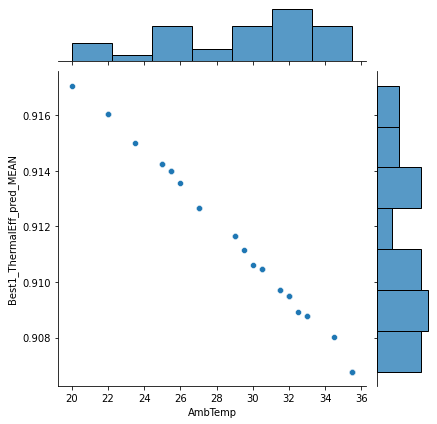

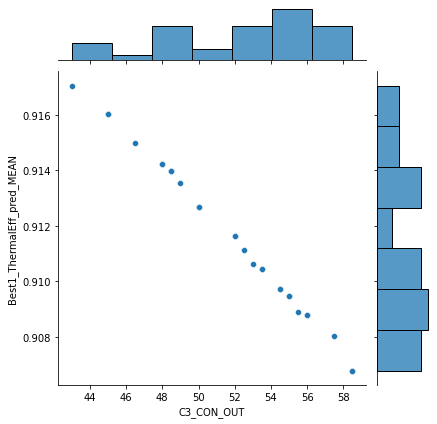

In [476]:
# Plot and check the sensitivity

target = [
    'AmbTemp',
    'C3_CON_OUT']

plt.figure(figsize=(12,6))

for each in target:
    sns.jointplot(x=each, y="Best1_ThermalEff_pred_MEAN", data=df_add)
plt.show()